# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import The Dataset

The data processed contains the the training data, validation data, and test data (with unmasked and masked label) that has been preprocessed. However, later on, we will further preprocess the code to increase the accuracy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("drive/MyDrive/sentiment-prosa/train_preprocess.tsv", sep='\t', header=None)
df_valid = pd.read_csv("drive/MyDrive/sentiment-prosa/valid_preprocess.tsv", sep='\t', header=None)
df_test_unmasked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess.tsv", sep='\t', header=None)
df_test_masked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess_masked_label.tsv", sep='\t', header=None)

Open the vocabulary document

In [ ]:
with open('drive/MyDrive/sentiment-prosa/vocab_uncased.txt', 'r') as f:
    vocab = f.read().splitlines()

In [ ]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


# Pre-processing

## Remove punctuation and numbers

In [ ]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [ ]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(remove_punctuation)
df_test_masked['text'] = df_test_masked['text'].apply(remove_punctuation)

vocab_filtered = []

for word in vocab:
  word_filtered = remove_punctuation(word)
  vocab_filtered.append(word_filtered)



In [ ]:
df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh jadi mahasiswa jangan sombong dong kas...,negative
5,makanan beragam harga makanan di food stall ...,positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,tempat unik bagus buat foto makanan enak ...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [ ]:
df_test_unmasked.head(10)

,text,emotion
0,kemarin gue datang ke tempat makan baru yang a...,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative
2,kalau dipikir pikir sebenarnya tidak ada yan...,negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative
5,pelayanan di hotel salak bogor tidak sebagus y...,negative
6,ada apa dengan young lex kenapa dia harus me...,negative
7,gue pesimis sama manusia terutama dalam ngur...,negative
8,saya kecewa karena pengeditan biodata penumpan...,negative
9,saya hari ini melakukan pemesanan dan tiket sa...,negative


# Exploratory Data Analysis

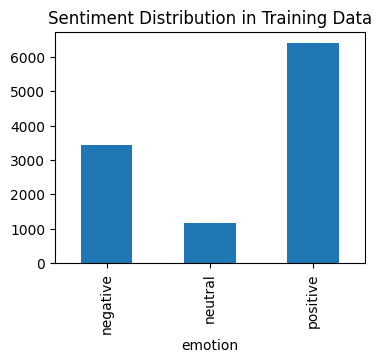

,text
emotion,
negative,3436
neutral,1148
positive,6416


In [ ]:
fig = plt.figure(figsize=(4,3))
df_train.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Sentiment Distribution in Training Data")
plt.show()
df_train.groupby('emotion').text.count()

In [ ]:
# Encoding emotions
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

# Experiment 1: Decision Tree

## Training

In [ ]:
# Create a bag of words from the vocab_uncased.txt
cleaned_vocab = [string.strip() for string in vocab_filtered if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

# Extract training, validation, and test data into each array and transform using vocabulary
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

In [ ]:
# Create Decision Tree model and train
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Validate data set
y_valid_pred = dt_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.7833333333333333
Precision: 0.7209693668765794
Recall: 0.7238963272370599
F1-Score: 0.7210858154527674
              precision    recall  f1-score   support

    negative       0.67      0.76      0.71       394
     neutral       0.60      0.58      0.59       131
    positive       0.89      0.83      0.86       735

    accuracy                           0.78      1260
   macro avg       0.72      0.72      0.72      1260
weighted avg       0.79      0.78      0.79      1260



In [ ]:
# Predict x column using DT model
y_test_pred = dt_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.584
Test Precision: 0.5619797632684231
Test Recall: 0.5297945518533754
Test F1-Score: 0.5295355515943752
Banyak data yang salah diprediksi: 208


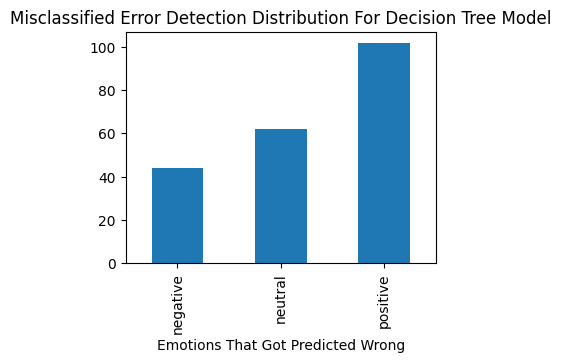

,text
emotion,
negative,44
neutral,62
positive,102


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Decision Tree Model")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 2: Hypertuning Parameters

In [ ]:
# Use hypertuning to get optimal results
parameters = {
    'max_depth': [5, 10, 20, 50, 100, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 300, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [ ]:
# Create Decision Tree model and train
dt_model = DecisionTreeClassifier(random_state=42, max_depth=300, min_samples_split=2, min_samples_leaf=10)
dt_model.fit(X_train, y_train)

# Validate data set
y_valid_pred = dt_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.7777777777777778
Precision: 0.7088539517720696
Recall: 0.7137921323707018
F1-Score: 0.7104469054235749
              precision    recall  f1-score   support

    negative       0.67      0.74      0.70       394
     neutral       0.57      0.56      0.57       131
    positive       0.88      0.84      0.86       735

    accuracy                           0.78      1260
   macro avg       0.71      0.71      0.71      1260
weighted avg       0.78      0.78      0.78      1260



In [ ]:
# Predict x column using DT model
y_test_pred = dt_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.58
Test Precision: 0.5593040735355727
Test Recall: 0.5269979203802734
Test F1-Score: 0.519102451472557
Banyak data yang salah diprediksi: 210


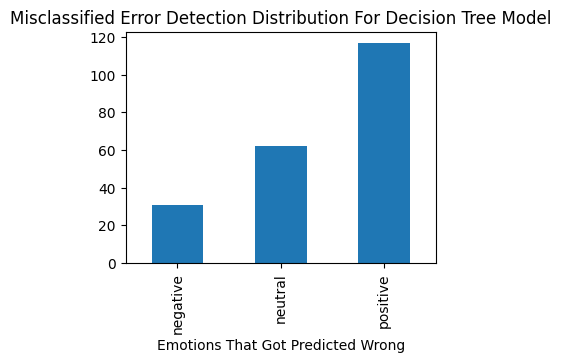

,text
emotion,
negative,31
neutral,62
positive,117


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Decision Tree Model")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()